Setup

# Setup

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (23060, 19)
   lapse  polholder_age polholder_BMCevol polholder_diffdriver  \
0      0             38            stable         only partner   
1      1             35            stable                 same   
2      1             29            stable                 same   
3      0             33              down                 same   
4      0             50            stable                 same   

  polholder_gender polholder_job  policy_age              policy_caruse  \
0             Male        normal           1  private or freelance work   
1             Male        normal           1  private or freelance work   
2             Male        normal           0  private or freelance work   
3           Female       medical           2  private or freelance work   
4             Male        normal           8                    unknown   

   p

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]


--- TabPFN ---
Accuracy: 0.872
AUC: 0.606
Confusion Matrix:
 [[6032    0]
 [ 886    0]]
              precision    recall  f1-score   support

           0      0.872     1.000     0.932      6032
           1      0.000     0.000     0.000       886

    accuracy                          0.872      6918
   macro avg      0.436     0.500     0.466      6918
weighted avg      0.760     0.872     0.812      6918


Best TabPFN threshold by F1: 0.10 (F1 = 0.256)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


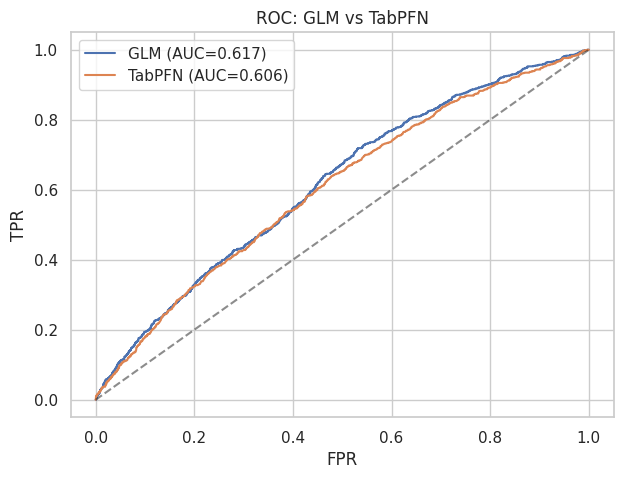

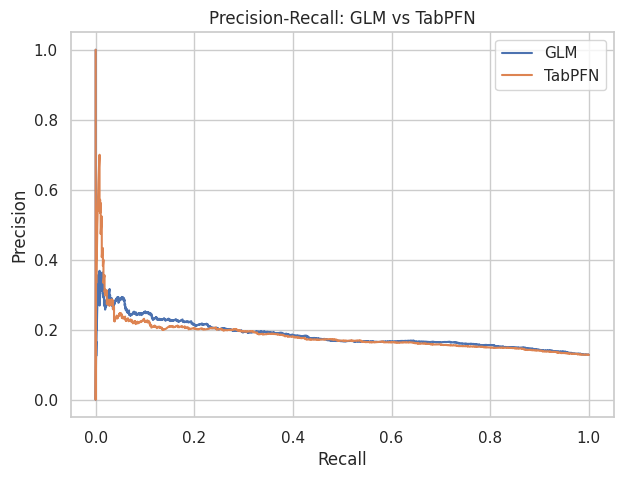

In [ ]:
# --- Install dependencies ---
!pip -q install pandas numpy scikit-learn matplotlib seaborn statsmodels
!pip -q install torch --index-url https://download.pytorch.org/whl/cpu
!pip -q install tabpfn

# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, accuracy_score,
                             f1_score, precision_recall_curve)

from tabpfn import TabPFNClassifier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,5)

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Load dataset (note: stored inside eudirectlapse folder) ---
df = pd.read_csv("/content/drive/MyDrive/eudirectlapse/eudirectlapse.csv")
print("Shape:", df.shape)
print(df.head())

# --- Train/Test split ---
y = df['lapse'].astype(int).values
X = df.drop(columns=['lapse']).copy()

# Separate categorical vs numerical columns
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Logistic Regression ---
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
pre_glm = ColumnTransformer(
    [('cat', ohe, cat_cols), ('num', 'passthrough', num_cols)]
)
glm = LogisticRegression(max_iter=500, n_jobs=-1, solver='lbfgs')
glm_pipe = Pipeline([('prep', pre_glm), ('clf', glm)])
glm_pipe.fit(X_train_df, y_train)

glm_probs = glm_pipe.predict_proba(X_test_df)[:,1]
glm_preds = (glm_probs >= 0.5).astype(int)

glm_acc = accuracy_score(y_test, glm_preds)
glm_auc = roc_auc_score(y_test, glm_probs)

print("\n--- Logistic Regression (GLM) ---")
print(f"Accuracy: {glm_acc:.3f}")
print(f"AUC: {glm_auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, glm_preds))
print(classification_report(y_test, glm_preds, digits=3))

# --- TabPFN ---
# Encode categoricals as integers
def integer_encode(df_in: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df_in.index)
    for c in df_in.columns:
        if df_in[c].dtype.kind in 'ifb':
            out[c] = pd.to_numeric(df_in[c])
        else:
            codes, _ = pd.factorize(df_in[c].astype(str), sort=True)
            out[c] = codes
    return out

X_full_int = integer_encode(X)
X_train_int = X_full_int.loc[X_train_df.index].to_numpy()
X_test_int  = X_full_int.loc[X_test_df.index].to_numpy()

# Cap TabPFN training at 10k
if len(X_train_int) > 10000:
    np.random.seed(42)
    idx = np.random.choice(len(X_train_int), size=10000, replace=False)
    X_train_tab = X_train_int[idx]
    y_train_tab = y_train[idx]
else:
    X_train_tab = X_train_int
    y_train_tab = y_train

tabpfn = TabPFNClassifier()
tabpfn.fit(X_train_tab, y_train_tab)

tab_probs = tabpfn.predict_proba(X_test_int)[:,1]
tab_preds = (tab_probs >= 0.5).astype(int)

tab_acc = accuracy_score(y_test, tab_preds)
tab_auc = roc_auc_score(y_test, tab_probs)

print("\n--- TabPFN ---")
print(f"Accuracy: {tab_acc:.3f}")
print(f"AUC: {tab_auc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, tab_preds))
print(classification_report(y_test, tab_preds, digits=3))

# --- Threshold tuning for TabPFN ---
ths = np.linspace(0.05, 0.95, 19)
f1s = []
for t in ths:
    preds = (tab_probs >= t).astype(int)
    f1s.append(f1_score(y_test, preds, zero_division=0))
best_t = ths[np.argmax(f1s)]
best_f1 = max(f1s)
print(f"\nBest TabPFN threshold by F1: {best_t:.2f} (F1 = {best_f1:.3f})")

# --- ROC curves ---
fpr_g, tpr_g, _ = roc_curve(y_test, glm_probs)
fpr_t, tpr_t, _ = roc_curve(y_test, tab_probs)
plt.plot(fpr_g, tpr_g, label=f"GLM (AUC={glm_auc:.3f})")
plt.plot(fpr_t, tpr_t, label=f"TabPFN (AUC={tab_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title("ROC: GLM vs TabPFN"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()

# --- Precision-Recall curves ---
prec_g, rec_g, _ = precision_recall_curve(y_test, glm_probs)
prec_t, rec_t, _ = precision_recall_curve(y_test, tab_probs)
plt.plot(rec_g, prec_g, label="GLM")
plt.plot(rec_t, prec_t, label="TabPFN")
plt.title("Precision-Recall: GLM vs TabPFN")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.show()
